In [3]:
import tensorflow as tf
import os
from keras.layers import *

2024-03-30 08:54:05.398662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 08:54:05.528329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 08:54:05.528383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 08:54:05.529765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 08:54:05.529808: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 2592)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 12, 12, 18)   0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 12, 12, 48)   7776        ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 12, 48)  192         ['conv2d[0][0]']                 
 alization)                                                                                   

ead NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 08:54:06.456748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9554 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


                                                                                                  
 conv2d_6 (Conv2D)              (None, 12, 12, 48)   20736       ['re_lu_7[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 12, 12, 48)  192         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 re_lu_8 (ReLU)                 (None, 12, 12, 48)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 add_2 (Add)                    (None, 12, 12, 48)   0           ['re_lu_8[0][0]',                
                                                                  're_lu_6[0][0]']                
          

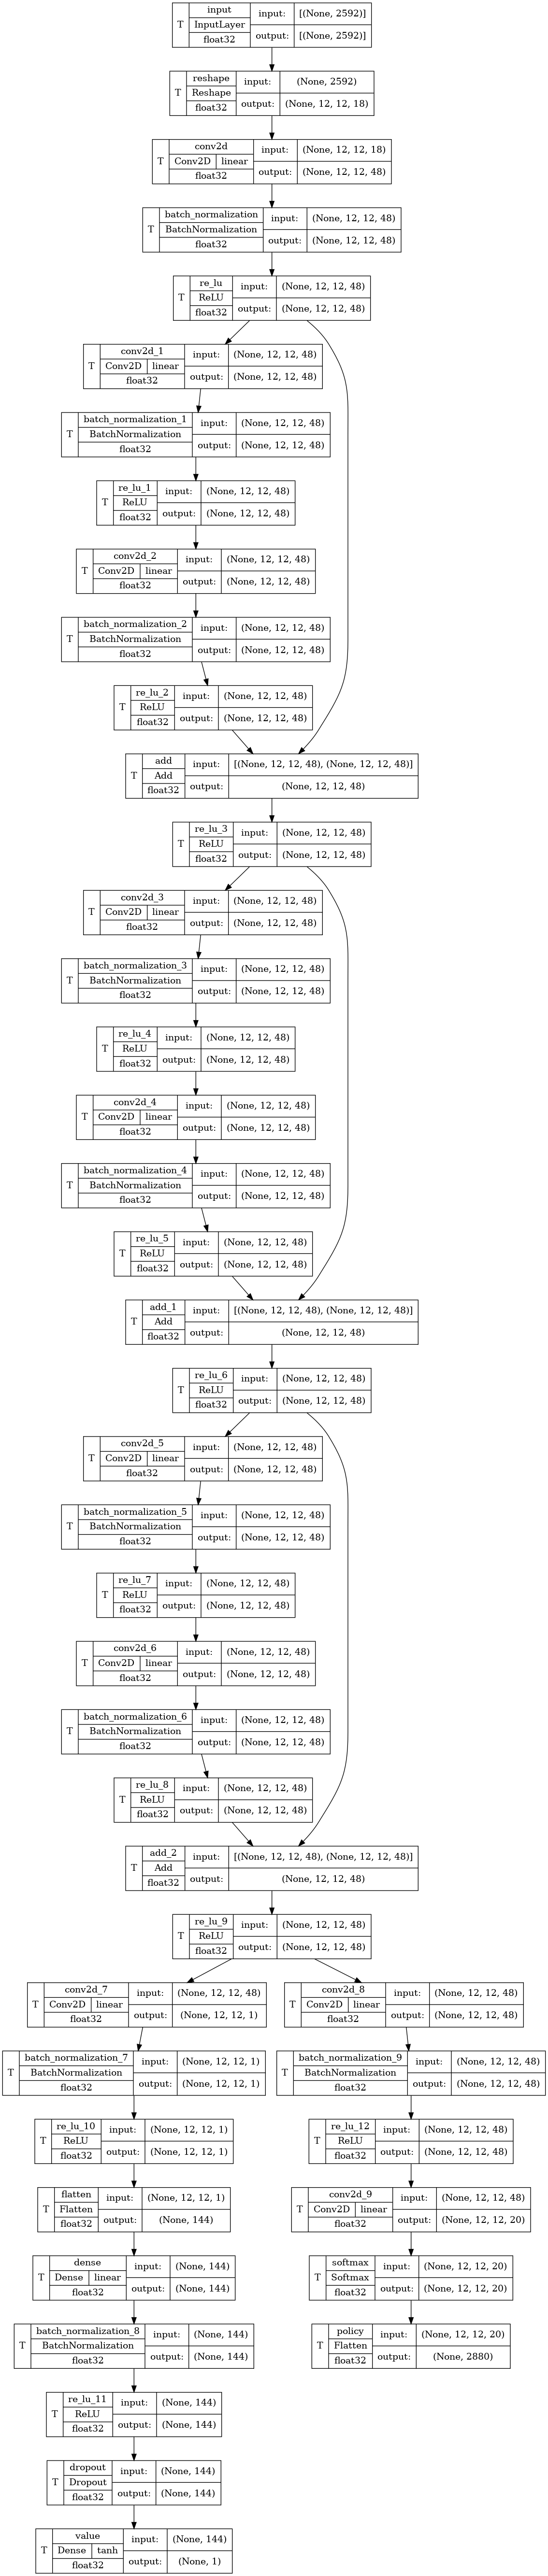

In [2]:
# INPUT_SPEC
BOARD_SIZE = 12
ACTIONS = 20
FACTIONS = 3  # FACTION_1, FACTION_2, NEUTRAL (ELEMENT)
IS_CONTROLLED = 1
ATTRIBUTES = 5
STATUES = 9  # should be an encoded process set?

# MODEL SPEC
CONV_FILTERS = 48
KERNEL = 3
NUM_RES_BLOCKS = 3
DROPOUT_RATE = 0.3


def res_block(y):
    r = Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', use_bias=False)(y)
    r = BatchNormalization()(r)
    r = ReLU()(r)
    r = Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', use_bias=False)(r)
    r = BatchNormalization()(r)
    r = ReLU()(r)
    r = Add()([r, y])
    r = ReLU()(r)
    return r


def build_model():
    input_layer = Input(name="input",
                        shape=(BOARD_SIZE * BOARD_SIZE * (FACTIONS + IS_CONTROLLED + ATTRIBUTES + STATUES)))
    x = Reshape(target_shape=(BOARD_SIZE, BOARD_SIZE, FACTIONS + IS_CONTROLLED + ATTRIBUTES + STATUES))(input_layer)
    x = Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    for _ in range(NUM_RES_BLOCKS):
        x = res_block(x)

    # value head
    vx = Conv2D(filters=1, kernel_size=1, padding='same', use_bias=False)(x)
    vx = BatchNormalization()(vx)
    vx = ReLU()(vx)
    vx = Flatten()(vx)
    vx = Dense(BOARD_SIZE * BOARD_SIZE, use_bias=False)(vx)
    vx = BatchNormalization()(vx)
    vx = ReLU()(vx)
    vx = Dropout(DROPOUT_RATE)(vx)
    vx = Dense(1, activation='tanh', name='value')(vx)
    value_output_layer = vx

    # policy head
    px = Conv2D(filters=CONV_FILTERS, kernel_size=1, padding='same', use_bias=False)(x)
    px = BatchNormalization()(px)
    px = ReLU()(px)
    px = Conv2D(filters=ACTIONS, kernel_size=1, padding='same', use_bias=True)(px)
    px = Softmax()(px)
    px = Flatten(name='policy')(px)
    policy_output_layer = px  # TODO mask them before softmax?

    return tf.keras.models.Model(inputs=input_layer, outputs=[policy_output_layer, value_output_layer])


model = build_model()
model.compile(loss=['categorical_crossentropy', 'mean_squared_error'], optimizer='adam', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)


In [18]:
# X-3, Y-3, Z-3
t1 = [1, 2, 3, 4, 5, # 0, 0
      0, 0, 0, 0, 0,
      0, 0, 0, 0, 0,
      0, 0, 0, 0, 0,
      0, 0, 0, 0, 0,
      0, 0, 0, 0, 0,
      0, 0, 0, 0, 0,
      6, 7, 8, 9, 10, # 2, 1
      0, 0, 0, 0, 0]
print(tf.shape(t1).numpy())

t2 = tf.reshape(t1, [3, 3, 5])

print(t2[2][1])


[45]
tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)


In [ ]:
def load_game_data(filepath):
    pass


In [5]:
model_save_path = "./player_zero_model/"
!mkdir winner_predictor_model

if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

tf.saved_model.save(model, model_save_path)


/bin/bash: /home/matpac/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


2024-03-30 08:55:39.542025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [?,2592]
	 [[{{node input}}]]
2024-03-30 08:55:39.673881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [?,2592]
	 [[{{node input}}]]
2024-03-30 08:55:39.723692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2592]
	 [[{{node inputs}}]]
2024-03-30 08:55:

INFO:tensorflow:Assets written to: ./player_zero_model/assets


INFO:tensorflow:Assets written to: ./player_zero_model/assets
